# How to write a custom dataset class

A typical strategy to improve generalization in deep neural networks is to increase the number of training examples which allows more parameters to be used in the model. Even if the number of parameters is kept unchanged, increasing the number of training examples often improves generalization performance.

Since it can be tedious and expensive to manually obtain and label additional training examples, a useful strategy is to consider methods for automatically increasing the size of a training set. Fortunately, for image datasets, there are several augmentation methods that have been found to work well in practice. They include:

* Randomly cropping several slightly smaller images from the original training image.
* Horizontally flipping the image.
* Randomly rotating the image.
* Applying various distortions and or noise to the images, etc.

In this example, we will write a custom dataset class that performs the first two of these augmentation methods on the CIFAR10 dataset. We will then train our previous deep CNN and check that the generalization performance on the test set has in fact improved.

We will create this dataset augmentation class as a subclass of `DatasetMixin`, which has the following API:

- `__len__` method to return the size of data in dataset. 
- `get_example` method to return data or a tuple of data and label, which are passed by `i` argument variable. 

Other necessary features for a dataset can be prepared by inheriting `chainer.dataset.DasetMixin` class. 

## 1. Write the dataset augmentation class for CIFAR10

In [1]:
import numpy as np
from chainer import dataset
from chainer.datasets import cifar

gpu_id = 0  # Set to -1 if you don't have a GPU

class CIFAR10Augmented(dataset.DatasetMixin):

    def __init__(self, train=True):
        train_data, test_data = cifar.get_cifar10()
        if train:
            self.data = train_data
        else:
            self.data = test_data
        self.train = train
        self.random_crop = 4

    def __len__(self):
        return len(self.data)

    def get_example(self, i):
        x, t = self.data[i]
        if self.train:
            x = x.transpose(1, 2, 0)
            h, w, _ = x.shape
            x_offset = np.random.randint(self.random_crop)
            y_offset = np.random.randint(self.random_crop)
            x = x[y_offset:y_offset + h - self.random_crop,
                  x_offset:x_offset + w - self.random_crop]
            if np.random.rand() > 0.5:
                x = np.fliplr(x)
            x = x.transpose(2, 0, 1)
        return x, t

This class performs the following types of data augmentation on the CIFAR10 example images:

- Randomly crop a 28X28 area form the 32X32 whole image data.
- Randomly perform a horizontal flip with 0.5 probability. 


## 2. Train on the CIFAR10 dataset using our dataset augmentation class

Let's now train the same deep CNN from the previous example. The only difference is that we will now use our dataset augmentation class. Since we reuse the same model with the same number of parameters, we can observe how much the augmentation improves the test set generalization performance.

In [2]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.datasets import cifar
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions

class ConvBlock(chainer.Chain):
    
    def __init__(self, n_ch, pool_drop=False):
        w = chainer.initializers.HeNormal()
        super(ConvBlock, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(None, n_ch, 3, 1, 1,
                                 nobias=True, initialW=w)
            self.bn = L.BatchNormalization(n_ch)
        
        
        self.pool_drop = pool_drop
        
    def __call__(self, x):
        h = F.relu(self.bn(self.conv(x)))
        if self.pool_drop:
            h = F.max_pooling_2d(h, 2, 2)
            h = F.dropout(h, ratio=0.25)
        return h

class LinearBlock(chainer.Chain):
    
    def __init__(self):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__()
        with self.init_scope():
            self.fc = L.Linear(None, 1024, initialW=w)
        
    def __call__(self, x):
        return F.dropout(F.relu(self.fc(x)), ratio=0.5)
    
class DeepCNN(chainer.ChainList):

    def __init__(self, n_output):
        super(DeepCNN, self).__init__(
            ConvBlock(64),
            ConvBlock(64, True),
            ConvBlock(128),
            ConvBlock(128, True),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256),
            ConvBlock(256, True),
            LinearBlock(),
            LinearBlock(),
            L.Linear(None, n_output)
        )
        
    def __call__(self, x):
        for f in self.children():
            x = f(x)
        return x

def train(model_object, batchsize=64, gpu_id=gpu_id, max_epoch=20):

    # 1. Dataset
    train, test = CIFAR10Augmented(), CIFAR10Augmented(False)

    # 2. Iterator
    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    # 3. Model
    model = L.Classifier(model_object)
    if gpu_id >= 0:
            model.to_gpu(gpu_id)

    # 4. Optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(model)

    # 5. Updater
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

    # 6. Trainer
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='{}_cifar10augmented_result'.format(model_object.__class__.__name__))

    # 7. Evaluator

    class TestModeEvaluator(extensions.Evaluator):

        def evaluate(self):
            model = self.get_target('main')
            ret = super(TestModeEvaluator, self).evaluate()
            return ret

    trainer.extend(extensions.LogReport())
    trainer.extend(TestModeEvaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.run()
    del trainer
    
    return model
    
model = train(DeepCNN(10), max_epoch=100, gpu_id=gpu_id)

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.97079     0.27106        1.53943               0.402667                  18.719        
2           1.46539     0.46725        1.32482               0.506071                  36.7491       
3           1.20546     0.578145       1.09062               0.599124                  54.8801       
4           1.03482     0.649488       0.940756              0.678145                  74.0606       
5           0.903032    0.700048       0.769937              0.738157                  94.1912       
6           0.818297    0.733995       0.725867              0.76244                   113.789       
7           0.754071    0.756422       0.651231              0.787221                  133.717       
8           0.691962    0.776288       0.803996              0.735967                  153.559       
9           0.637998    0.793738       0.566224              0.812799               

In the case without the previous data augmentation, it was found that the precision which was capped at about 87% can be improved to 89% or more by applying augmentation to the learning data. It is an improvement of over 2%.

Finally, let's take a look at the loss and precision graph.

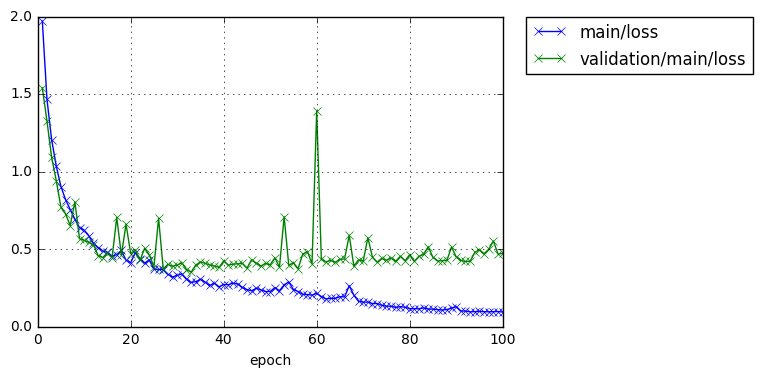

In [3]:
from IPython.display import Image
Image(filename='DeepCNN_cifar10augmented_result/loss.png')

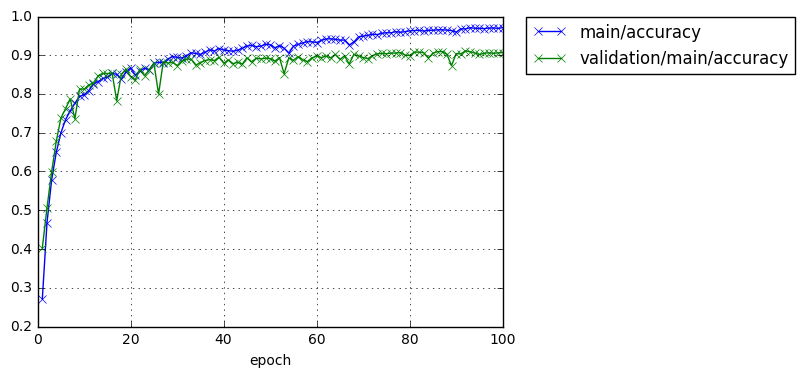

In [4]:
Image(filename='DeepCNN_cifar10augmented_result/accuracy.png')